In [1]:
import pydicom # module for reading dicom files
import os # module for interfacing with the os
import numpy as np # numpy for arrays etc
import pandas as pd # module for creating and querying data tables (databases) efficiently
import pylidc as pl # module for handling the LIDC dataset
import matplotlib.pyplot as plt # plotting utilities
import pdb # debugger
import scipy.ndimage # 
import scipy.sparse
from tqdm import tqdm_notebook
import scipy
from utils.preprocess_functions import *
from pylidc.utils import consensus
from skimage import measure, morphology
from skimage.morphology import ball, dilation, disk, erosion
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [2]:
# Compared to the previous version (v2), this script removes the scans with bad
# slices (>2.5mm or inconsistency between spacing and thickness)

In [3]:
# Set up the relevant paths

LIDC_PATH = '/data/datasets/LIDC-IDRI/' # original LIDC data
# annotations = pd.read_csv('/data/datasets/LIDC-IDRI/annotations.csv')
LIDC_IDs = os.listdir(f'{LIDC_PATH}LIDC-IDRI')
LIDC_IDs = [i for i in LIDC_IDs if 'LIDC' in i]
LIDC_IDs = np.sort(LIDC_IDs)

# output path
path_dest = f'/data/OMM/Datasets/LIDC_other_formats/LIDC_preprocessed_3D v2/'
if not os.path.exists(path_dest): os.makedirs(path_dest)

preprocessing: 927, LIDC-IDRI-0930
Loading and converting to HU
Loading dicom files ... This may take a moment.
Resampling to isotropic resolution
Segmenting the lungs and dilating the mask
Finding nodule masks
Saving...
preprocessing: 928, LIDC-IDRI-0931
Loading and converting to HU
Loading dicom files ... This may take a moment.
Resampling to isotropic resolution
Segmenting the lungs and dilating the mask
Finding nodule masks
Saving...
preprocessing: 929, LIDC-IDRI-0932
Loading and converting to HU
Loading dicom files ... This may take a moment.
Resampling to isotropic resolution
Segmenting the lungs and dilating the mask
Finding nodule masks
Saving...
preprocessing: 930, LIDC-IDRI-0933
Loading and converting to HU
Loading dicom files ... This may take a moment.
Resampling to isotropic resolution
Segmenting the lungs and dilating the mask
Finding nodule masks
Saving...
preprocessing: 931, LIDC-IDRI-0934
Loading and converting to HU
Loading dicom files ... This may take a moment.
Resa

Resampling to isotropic resolution
Segmenting the lungs and dilating the mask
Finding nodule masks
Saving...
preprocessing: 970, LIDC-IDRI-0973
Loading and converting to HU
Loading dicom files ... This may take a moment.
Resampling to isotropic resolution
Segmenting the lungs and dilating the mask
Finding nodule masks
Saving...
preprocessing: 971, LIDC-IDRI-0974
Loading and converting to HU
Loading dicom files ... This may take a moment.
Resampling to isotropic resolution
Segmenting the lungs and dilating the mask
Finding nodule masks
Saving...
preprocessing: 972, LIDC-IDRI-0975
Loading and converting to HU
Loading dicom files ... This may take a moment.
Resampling to isotropic resolution
Segmenting the lungs and dilating the mask
Finding nodule masks
Saving...
preprocessing: 973, LIDC-IDRI-0976
Loading and converting to HU
Loading dicom files ... This may take a moment.
Resampling to isotropic resolution
Segmenting the lungs and dilating the mask
Finding nodule masks
Saving...
preproc

Segmenting the lungs and dilating the mask
Finding nodule masks
Saving...


Text(0.5,0,'Number of voxels in segmentation')

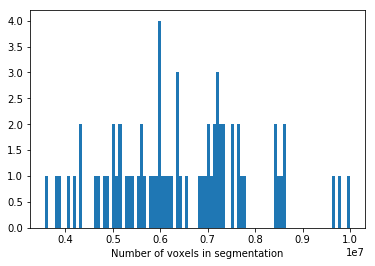

In [4]:
# Get all the scans for X patient(s)
df = pd.read_csv('/data/datasets/LIDC-IDRI/annotations.csv')

#%%
scans_with_errors = []
errorScansFile = open(path_dest + "scans_with_errors.txt","w")

numVoxelsPerLungSeg = []
listOfRejectedPatients = []
rejectListFile = open(path_dest + "rejectedPatients.txt","w") 

listOfUsedPatients = []
useListFile = open(path_dest + "usedPatients.txt","w") 

requiredSelemWidth = []
selemZWidthFile = open(path_dest + "segmentationSelemZWidths.txt","w") 

for idx, k in enumerate(LIDC_IDs):

    if idx <927:continue
    
#    #idx = 11
#    #idx = 611
#    idx = 309
#    k = LIDC_IDs[idx]

    #if idx>5:break
    print(f'preprocessing: {idx}, {k}')
       
    df_patient = df.loc[df['patientid']==int(k[-4:])] 
    pid = k
    
    # query the LIDC images with patient_id = pid 
    # HERE WE JUST USE THE FIRST ONE!!
    idx_scan = 0 
    
    # get the scan object for this scan
    scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid)[idx_scan] 
    
    # here we can reject according to any criteria we like
    thickSlice = (scan.slice_thickness > 3) | (scan.slice_spacing > 3)
    missingSlices = len(np.unique(np.round(100*np.diff(scan.slice_zvals)))) != 1
    if (thickSlice)  :
        # we want to reject this scan/patient
        print('Undesirable slice characteristics, rejecting')
        listOfRejectedPatients.append(pid)
        continue
    elif (missingSlices):
        print('#################################')
        listOfRejectedPatients.append(pid)
        continue
    else:
        # we will use this scan
        listOfUsedPatients.append(pid)
        #continue # this lets us quickly check the outcome of the selection
    
    print('Loading and converting to HU')
    curr_patient_pixels, spacing_orig = custom_load_scan_to_HU(scan)

    print('Resampling to isotropic resolution')
    pix_resampled, spacing = resample_grid(curr_patient_pixels, spacing_orig, [1,1,1])
    
    print('Segmenting the lungs and dilating the mask')
    segmented_lungs_fill, requiredSelemWidthTmp = segment_lung_mask_SE(pix_resampled, True)
    requiredSelemWidth.append(requiredSelemWidthTmp)
    # Dilate the mask
    selem = ball(5) # radius of 5 mm
    dilated = dilation(segmented_lungs_fill, selem) # dilate a bit according to the tut
    # Apply the mask
    pix_resampled_to_use = pix_resampled*dilated
    # count the number of lung voxels to find those which are badly segmented
    numVoxelsPerLungSeg.append(np.count_nonzero(dilated))
    
    print('Finding nodule masks')
    # The mask
    # put the mask on an array with the same shape as the original volume
    one_segmentation_consensus = np.zeros_like(curr_patient_pixels)
    one_segmentation_maxvol = np.zeros_like(curr_patient_pixels)
     
    # get all the annotations for this scan
    ids = [i.id for i in scan.annotations] # this gives the annotation IDs (note that they are not in order in the annotations.csv)
     
    # we split the df for patient pid into the part for just this scan
    df_patient_partX = df_patient.loc[df_patient.annotation_id.isin(ids)]
    unique_nodules = np.unique(df_patient_partX['cluster_id'].values)
    nods = scan.cluster_annotations() # get the annotations for all nodules in this scan

    for unique_nodule in unique_nodules:
        df_nodule = df_patient_partX.loc[df_patient_partX['cluster_id']==unique_nodule] # this gives all annotations for this nodule (cluster)
     
        anns = nods[unique_nodule] # then choose the annotation for the nodule we are considering
    
        try:
            # cmask = consensus mask, cbbox = consensus bounding box, masks = original annotations
            cmask,cbbox,masks = consensus(anns, clevel=0.5, pad=[(0,0), (0,0), (0,0)])
        except NameError:
            scans_with_errors.append(pid)
            continue
     
        # we want to save the consensus AND the mask of all segmented voxels in all annotations
        one_mask_consensus = cmask
        one_mask_maxvol = np.zeros_like(cmask)
        for mask in masks:
            one_mask_maxvol = (one_mask_maxvol > 0) | (mask > 0)    
        
        # pylidc loads in a different order to our custom 3D dicom reader, so need to swap dims
        one_mask_consensus = np.swapaxes(one_mask_consensus,1,2);one_mask_consensus = np.swapaxes(one_mask_consensus,0,1)
        one_mask_maxvol = np.swapaxes(one_mask_maxvol,1,2);one_mask_maxvol = np.swapaxes(one_mask_maxvol,0,1)
        
        # fill the consensus bounding box with the mask to get a nodule segmentation in original image space (presumably the cbbox is big enough for all the individual masks)
        one_segmentation_consensus[cbbox[2].start:cbbox[2].stop,cbbox[0].start:cbbox[0].stop,cbbox[1].start:cbbox[1].stop] = one_mask_consensus
        one_segmentation_maxvol[cbbox[2].start:cbbox[2].stop,cbbox[0].start:cbbox[0].stop,cbbox[1].start:cbbox[1].stop] = one_mask_maxvol

    pass 

    # Resample the nodule segmentation
    mask_consensus_resampled, _ = resample_grid(one_segmentation_consensus, spacing_orig, [1,1,1]) # first patient still has the voxel size of the original image to enable the resampling
    mask_maxvol_resampled, _ = resample_grid(one_segmentation_maxvol, spacing_orig, [1,1,1]) # first patient still has the voxel size of the original image to enable the resampling

    print('Saving...')
    # now we save the results, saving each slice as a sparse array to cut down on size!
    # (currently just saving the last nodule per scan?)
    if not os.path.exists(f'{path_dest}{k}/scans'): os.makedirs(f'{path_dest}{k}/scans')
    if not os.path.exists(f'{path_dest}{k}/consensus_masks'): os.makedirs(f'{path_dest}{k}/consensus_masks')
    if not os.path.exists(f'{path_dest}{k}/maxvol_masks'): os.makedirs(f'{path_dest}{k}/maxvol_masks')
    if not os.path.exists(f'{path_dest}{k}/lung_masks'): os.makedirs(f'{path_dest}{k}/lung_masks')

    for idj,(slice_pix, slice_mask_consensus, slice_mask_maxvol,slice_lungseg) in enumerate(zip(pix_resampled_to_use, mask_consensus_resampled, mask_maxvol_resampled,dilated)):
        sparse_matrix = scipy.sparse.csc_matrix(slice_pix)
        sparse_matrix2 = scipy.sparse.csc_matrix(slice_mask_consensus)
        sparse_matrix3 = scipy.sparse.csc_matrix(slice_mask_maxvol)
        sparse_matrix4 = scipy.sparse.csc_matrix(slice_lungseg)
        
        scipy.sparse.save_npz(f'{path_dest}{k}/scans/slice_{idj:04d}.npz', sparse_matrix, compressed=True)
        scipy.sparse.save_npz(f'{path_dest}{k}/consensus_masks/slice_m_{idj:04d}.npz', sparse_matrix2, compressed=True)
        scipy.sparse.save_npz(f'{path_dest}{k}/maxvol_masks/slice_m_{idj:04d}.npz', sparse_matrix3, compressed=True)
        scipy.sparse.save_npz(f'{path_dest}{k}/lung_masks/slice_m_{idj:04d}.npz', sparse_matrix4, compressed=True)

#%% save some summary output
np.savetxt('segmentation_results.dat', numVoxelsPerLungSeg)

np.savetxt(rejectListFile,listOfRejectedPatients,'%10s')
rejectListFile.close()

np.savetxt(useListFile,listOfUsedPatients,'%10s')
useListFile.close()

np.savetxt(selemZWidthFile,requiredSelemWidth,'%u')
selemZWidthFile.close()

np.savetxt(errorScansFile,scans_with_errors,'%10s')
errorScansFile.close()

#%% plot segmentation results
ax = plt.hist(numVoxelsPerLungSeg,100)
plt.xlabel('Number of voxels in segmentation')